In [1]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element

import scipy.constants as const

In [2]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# 3D plotting
import plotly.graph_objects as go

# Specify which plots are desired
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = False

In [3]:
"""CalcIntFromElecField(_arI, _inWfr, _inPol, _inIntType, _inDepType, _inE, _inX, _inY)
function calculates/"extracts" Intensity from pre-calculated Electric Field
:param _arI: output resulting Intensity array (should be allocated in Python script before calling this function)
:param _inWfr: input pre-calculated Wavefront structure (instance of SRWLWfr)
:param _inPol: input switch specifying polarization component to be extracted:
               =0 -Linear Horizontal; 
               =1 -Linear Vertical; 
               =2 -Linear 45 degrees; 
               =3 -Linear 135 degrees;
               =4 -Circular Right; 
               =5 -Circular Left; 
               =6 -Total
:param _inIntType: input switch specifying "type" of a characteristic to be extracted:
               =0 -"Single-Electron" Intensity; 
               =1 -"Multi-Electron" Intensity; 
               =2 -"Single-Electron" Flux; 
               =3 -"Multi-Electron" Flux; 
               =4 -"Single-Electron" Radiation Phase; NOTE: requires DOUBLE PRECISION array via srwlib.array('d', ...)
               =5 -Re(E): Real part of Single-Electron Electric Field;
               =6 -Im(E): Imaginary part of Single-Electron Electric Field;
               =7 -"Single-Electron" Intensity, integrated over Time or Photon Energy (i.e. Fluence)
               =8 -"Single-Electron" Mutual Intensity (i.e. E(r)E*(r')) 
:param _inDepType: input switch specifying type of dependence to be extracted:
               =0 -vs e (photon energy or time);
               =1 -vs x (horizontal position or angle);
               =2 -vs y (vertical position or angle);
               =3 -vs x&y (horizontal and vertical positions or angles);
               =4 -vs e&x (photon energy or time and horizontal position or angle);
               =5 -vs e&y (photon energy or time and vertical position or angle);
               =6 -vs e&x&y (photon energy or time, horizontal and vertical positions or angles);
:param _inE: input photon energy [eV] or time [s] to keep fixed (to be taken into account for dependences vs x, y, x&y)
:param _inX: input horizontal position [m] to keep fixed (to be taken into account for dependences vs e, y, e&y)
:param _inY: input vertical position [m] to keep fixed (to be taken into account for dependences vs e, x, e&x)
"""
import srwlib
from srwlib import srwl

In [4]:
# instantiate the crystal with laser pumping on
L_crystal = 0.01   # [m]
_n0 = 1.76
_n2 = 16.          # [m^-2]
num_slices = 1

crystal_params = PKDict(
        n0 = _n0,
        n2 = _n2,
        length = L_crystal,
        nslice = num_slices,
)

crystal_pump_on = element.Crystal(crystal_params)

# next instantiate a crystal with pumping turned off
# crystal_params.n2 = 0.0
crystal_params.n2 = 4.0
crystal_pump_off = element.Crystal(crystal_params)

In [5]:
# define a simple lattice with a pumped crystal
L_drift_1 = 1.00  # [m]
L_drift_2 = 0.50  # [m]
drift_1 = element.Drift(L_drift_1)
drift_2 = element.Drift(L_drift_2)

lattice_pump_on = [(drift_1,'default'), (crystal_pump_on,'abcd'), (drift_2,'default')]

# next, define the same lattice with no pumping of the crystal
lattice_pump_off = [(drift_1,'default'), (crystal_pump_off,'abcd'), (drift_2,'default')]

In [6]:
# specify parameters
_sigrW = 1.275e-3 / math.sqrt(2.)
_slice_params = PKDict(
    sigrW=_sigrW,
    propLen=15,
    pulseE=0.001,
    poltype=1,
    sampFact=2.,
    mx=0,
    my=0,
)
_z_waist=-L_drift_1
_z_center=0.0
_d_to_w=_z_center-_z_waist
pulse_params = PKDict(
        phE=1.55,
        nslice=1,
        chirp=0,
        w0=1.275e-3,
        a0=.01,
        dw0x=0.0,
        dw0y=0.0,
        z_waist=_z_waist,
        dzwx=0.0,
        dzwy=0.0,
        tau_fwhm=2.e-10,
        z_center=_z_center,
        x_shift = 0.,
        y_shift=0.,
        d_to_w=_d_to_w,
        slice_params=_slice_params,
)

In [7]:
# Instantiate the laser pulse
pulseCenter = pulse.LaserPulse(pulse_params)  # this represents the part that sees the pumped region of the crystal
pulseWings = pulse.LaserPulse(pulse_params)   # this represents the part that sees the crystal outside the pump laser radius

In [8]:
# initial pulse - intensity

# choose one of the laser pulse slices, and grab its SRW wavefront object
slice_array=pulseCenter.slice
slice_number = 0
wfr0=slice_array[slice_number].wfr

intensity0 = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity0, wfr0, 0, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_0 = np.array(intensity0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(intensity0)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_0))
x0=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
y0=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


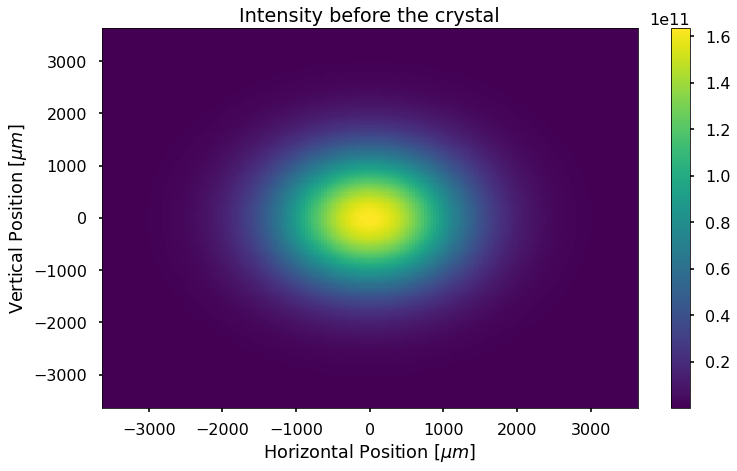

In [9]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x0,1e6), np.multiply(y0,1e6), intens_2d_0, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Intensity before the crystal')

In [10]:
# plot the 3D intensity
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x0, y=y0, z=intens_2d_0)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Laser pulse intensity before the crystal', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [11]:
# initial pulse - phase
wfr1=slice_array[slice_number].wfr

phase1 = srwlib.array('d', [0]*wfr1.mesh.nx*wfr1.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase1, wfr1, 0, 4, 3, wfr1.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_1 = np.array(phase1).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
wfrsize=np.size(phase1)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_1))
x1=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
y1=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


 
 phase_diff = 0.579 [rad] = 9.217 %
 


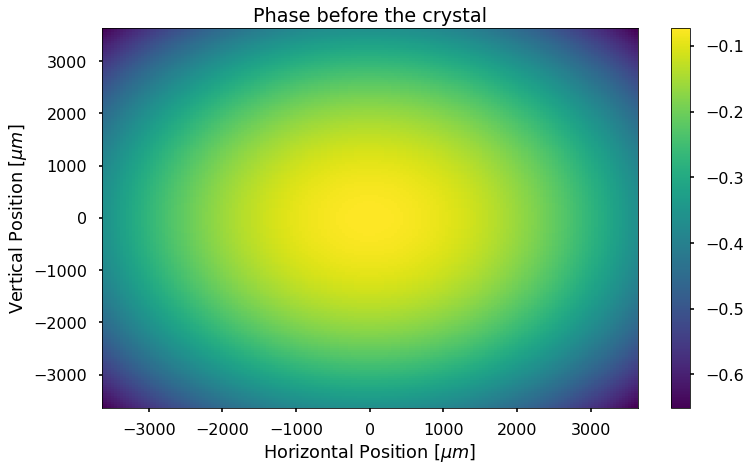

In [12]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x1,1e6), np.multiply(y1,1e6), phase_2d_1, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Phase before the crystal')
    
    phi_diff = np.max(phase_2d_1) - np.min(phase_2d_1)
    phi_rel_diff = 100. * phi_diff / math.pi / 2.
    print(' ')
    print(' phase_diff = {0:4.3f} [rad]'.format(phi_diff) + ' = {0:4.3f} %'.format(phi_rel_diff))
    print(' ')

In [13]:
# plot the 3D phase information
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=phase_2d_1)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Wavefront phases before the crystal', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [14]:
#  Propagate the pulse through the pumped Ti:Sapphire crystal:
for i in lattice_pump_on:
    current_elem, prop_type = i 
    pulseCenter = current_elem.propagate(pulseCenter, prop_type)

Propagated pulse slice  1  of  1


In [15]:
# transmitted pulse - intensity
wfr2=slice_array[slice_number].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


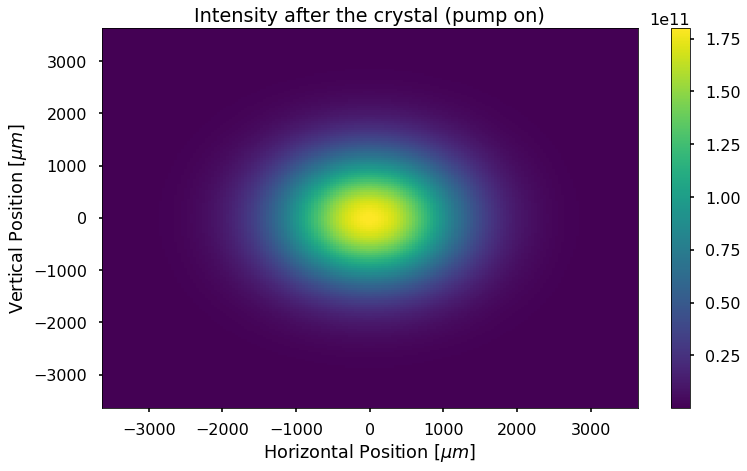

In [16]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x2,1e6), np.multiply(y2,1e6), intens_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Intensity after the crystal (pump on)')

In [17]:
# plot the 3D intensity
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x2, y=y2, z=intens_2d_2)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Laser pulse intensity after the crystal (pump on)', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [18]:
# transmitted pulse - phase
wfr3=slice_array[slice_number].wfr

phase3 = srwlib.array('d', [0]*wfr3.mesh.nx*wfr3.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase3, wfr3, 0, 4, 3, wfr3.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_3 = np.array(phase3).reshape((wfr3.mesh.nx, wfr3.mesh.ny), order='C')
wfrsize=np.size(phase3)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_3))
x3=np.linspace(wfr3.mesh.xStart,wfr3.mesh.xFin,wfr3.mesh.nx)
y3=np.linspace(wfr3.mesh.yStart,wfr3.mesh.yFin,wfr3.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


 
 phase_diff = 6.280 [rad] = 99.950 %
 


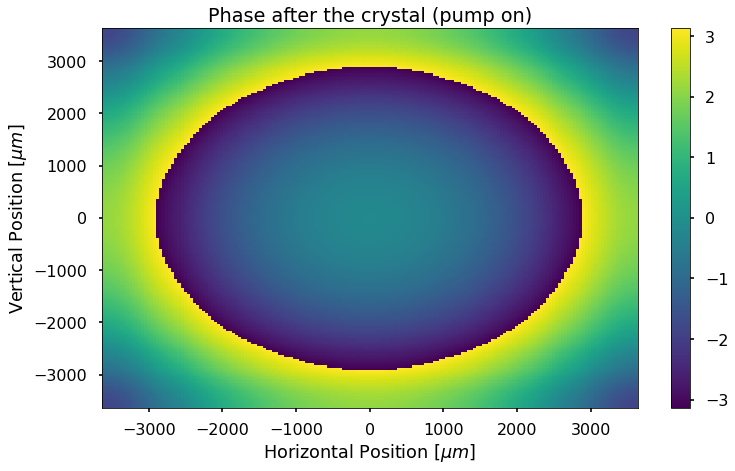

In [19]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x3,1e6), np.multiply(y3,1e6), phase_2d_3, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Phase after the crystal (pump on)')
    
    phi_diff = np.max(phase_2d_3) - np.min(phase_2d_3)
    phi_rel_diff = 100. * phi_diff / math.pi / 2.
    print(' ')
    print(' phase_diff = {0:4.3f} [rad]'.format(phi_diff) + ' = {0:4.3f} %'.format(phi_rel_diff))
    print(' ')

In [20]:
# plot the 3D phase information
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x3, y=y3, z=phase_2d_3)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Wavefront phases after the crystal (pump on)', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [21]:
# simulated phase range
phi_min = -2.3  # [rad]
phi_max = -0.234 + 2.*math.pi
delta_phi = phi_max - phi_min
print('phase range (simulated) = {0:4.2f} '.format(delta_phi))

# measured phase range
delta_phi = 2*4.96
print('phase range (measured)  = {0:4.2f} '.format(delta_phi))

phase range (simulated) = 8.35 
phase range (measured)  = 9.92 


In [22]:
# Propagate the pulse through the Ti:Sapphire crystal with no pumping:
for i in lattice_pump_off:
    current_elem, prop_type = i 
    pulseWings = current_elem.propagate(pulseWings, prop_type)

Propagated pulse slice  1  of  1


In [23]:
# transmitted pulse - intensity
slice_array_wings=pulseWings.slice
slice_number = 0
wfr4=slice_array_wings[slice_number].wfr

intensity4 = srwlib.array('f', [0]*wfr4.mesh.nx*wfr4.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity4, wfr4, 0, 0, 3, wfr4.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_4 = np.array(intensity4).reshape((wfr4.mesh.nx, wfr4.mesh.ny), order='C')
wfrsizei=np.size(intensity4)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_4))
x4=np.linspace(wfr4.mesh.xStart,wfr4.mesh.xFin,wfr4.mesh.nx)
y4=np.linspace(wfr4.mesh.yStart,wfr4.mesh.yFin,wfr4.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


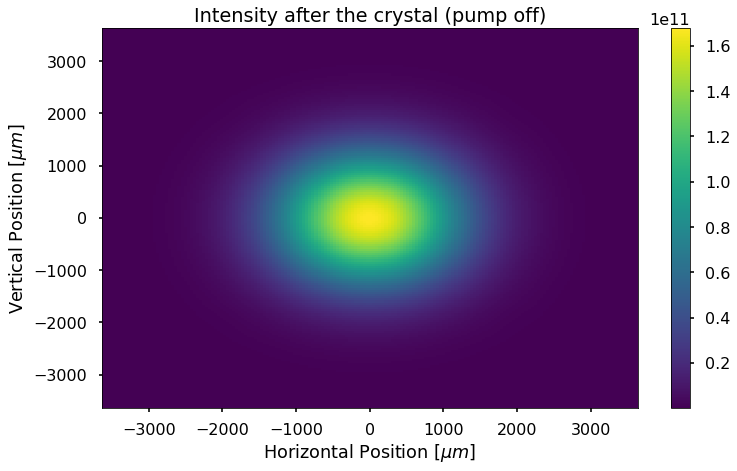

In [24]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x2,1e6), np.multiply(y2,1e6), intens_2d_4, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Intensity after the crystal (pump off)')

In [25]:
# plot the 3D intensity
# if RENDER_3D_PLOTS:
if False:
    fig = go.Figure(data=[go.Surface(x=x4, y=y4, z=intens_2d_4)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Laser pulse intensity after the crystal (pump off)', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [26]:
# transmitted pulse - phase
wfr5=slice_array_wings[slice_number].wfr

phase5 = srwlib.array('d', [0]*wfr5.mesh.nx*wfr5.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase5, wfr5, 0, 4, 3, wfr5.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_5 = np.array(phase5).reshape((wfr5.mesh.nx, wfr5.mesh.ny), order='C')
wfrsize=np.size(phase5)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_5))
x5=np.linspace(wfr5.mesh.xStart,wfr5.mesh.xFin,wfr5.mesh.nx)
y5=np.linspace(wfr5.mesh.yStart,wfr5.mesh.yFin,wfr5.mesh.ny)

Size of initial wavefront data array (coordinate): (176, 176)


 
 phase_diff = 1.307 [rad] = 20.798 %
 


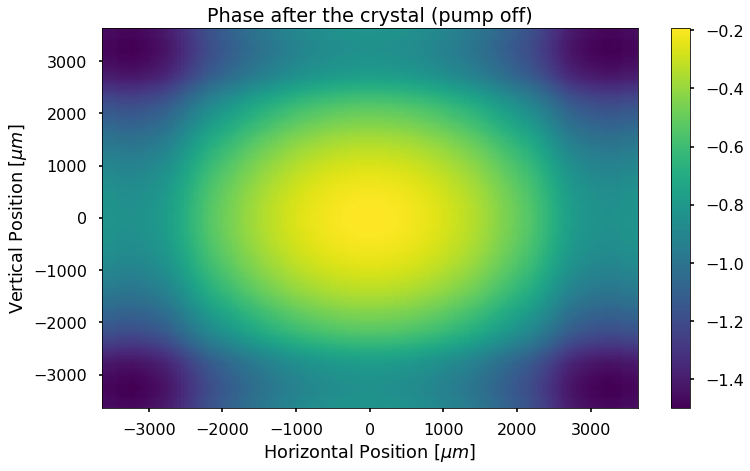

In [27]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x5,1e6), np.multiply(y5,1e6), phase_2d_5, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Phase after the crystal (pump off)')
    
    phi_diff = np.max(phase_2d_5) - np.min(phase_2d_5)
    phi_rel_diff = 100. * phi_diff / math.pi / 2.
    print(' ')
    print(' phase_diff = {0:4.3f} [rad]'.format(phi_diff) + ' = {0:4.3f} %'.format(phi_rel_diff))
    print(' ')

In [28]:
# plot the 3D phase information
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x5, y=y5, z=phase_2d_5)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Wavefront phases after the crystal (pump off)', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

In [29]:
# r_pump = 5.e-4  # [m]
r_pump = 2.e-3  # [m]

x, y = np.meshgrid(x3, y3)
r = np.sqrt(np.power(x,2) + np.power(y,2))

phase_center = np.where(r<r_pump, phase_2d_3+(4.8/3.)*math.pi, 0.)
phase_wings = np.where(r>r_pump, phase_2d_5-math.pi, 0.)
phase_combo = phase_center + phase_wings

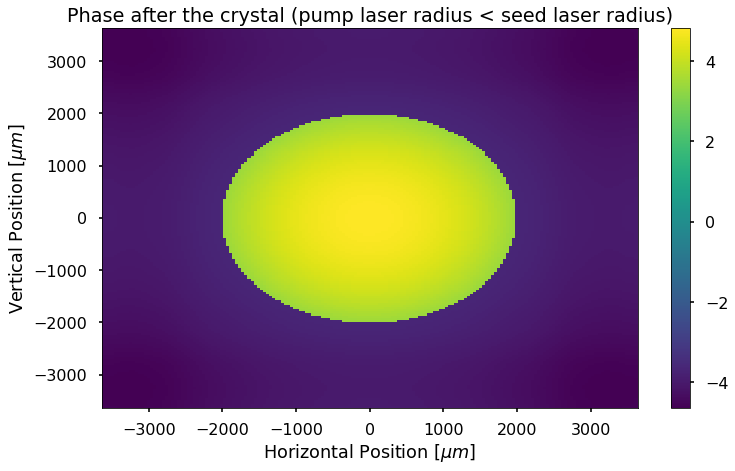

In [30]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(np.multiply(x3,1e6), np.multiply(y3,1e6), phase_combo, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [$\mu m$]')
        ax.set_xlabel(r'Horizontal Position [$\mu m$]')
        ax.set_title('Phase after the crystal (pump laser radius < seed laser radius)')

In [31]:
# plot the 3D phase information
if RENDER_3D_PLOTS:
    fig = go.Figure(data=[go.Surface(x=x3, y=y3, z=phase_combo)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
        highlightcolor="limegreen", project_z=True)
    )
    fig.update_layout(title='Wavefront phases after the crystal (pump laser radius < seed laser radius)', autosize=False,
        width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()